In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [5]:
from zipfile import ZipFile
file_name = "lung_image_sets.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [7]:
path = 'lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

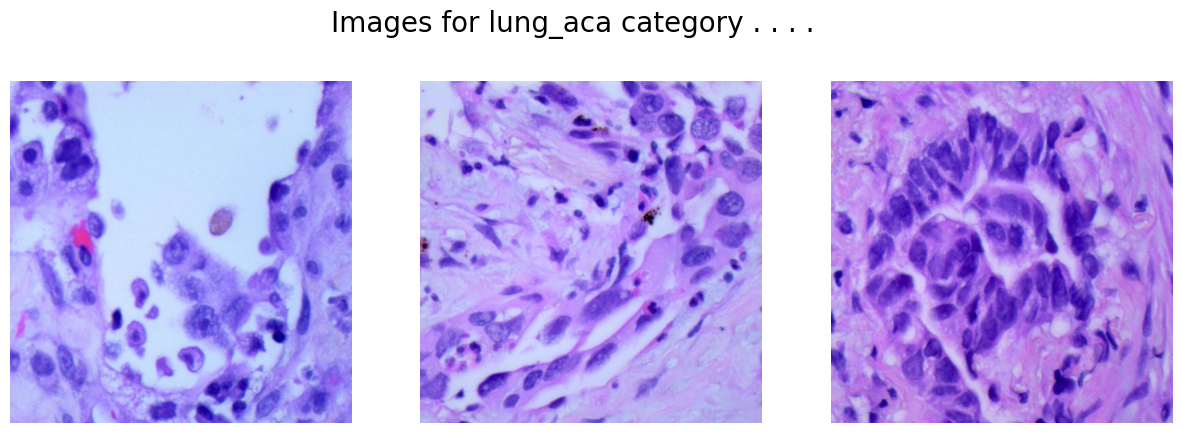

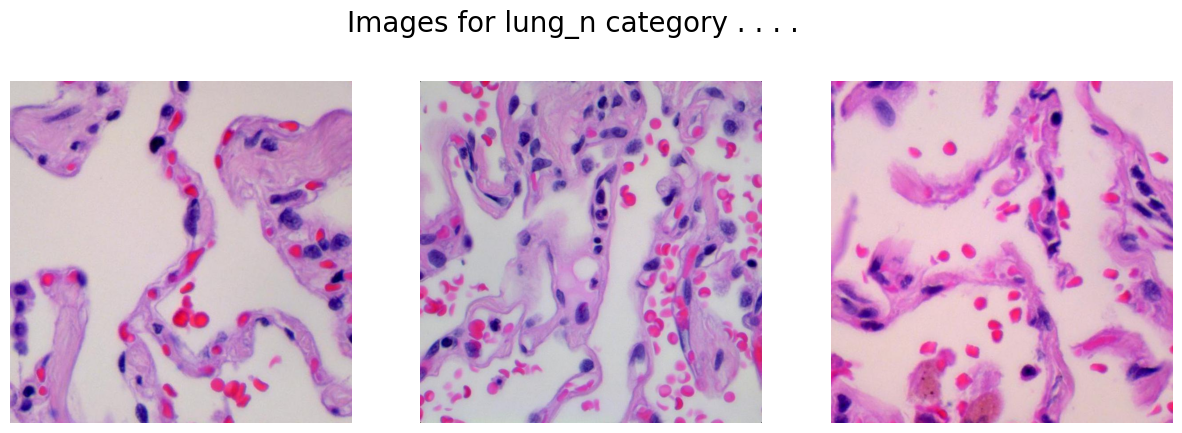

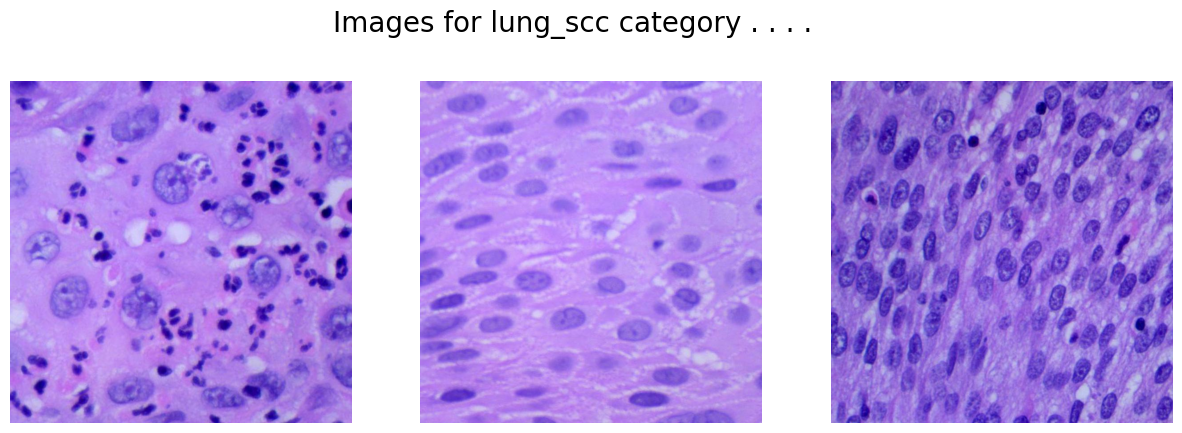

In [9]:
path = 'lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [10]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [11]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step 


In [14]:
len(pre_trained_model.layers)

311

In [15]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [16]:
last_layer = pre_trained_model.get_layer('mixed7')
output_shape = last_layer.input[0].shape

print('last layer output shape: ', output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 192)


In [17]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

In [18]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

In [20]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 778s 4s/step - accuracy: 0.7982 - loss: 0.4885 - val_accuracy: 0.8827 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 782s 4s/step - accuracy: 0.9061 - loss: 0.2358 - val_accuracy: 0.8983 - val_loss: 0.2402 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9280 - loss: 0.1782   
 Validation accuracy has reached upto 90%      so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 773s 4s/step - accuracy: 0.9280 - loss: 0.1781 - val_accuracy: 0.9023 - val_loss: 0.2573 - learning_rate: 0.0010


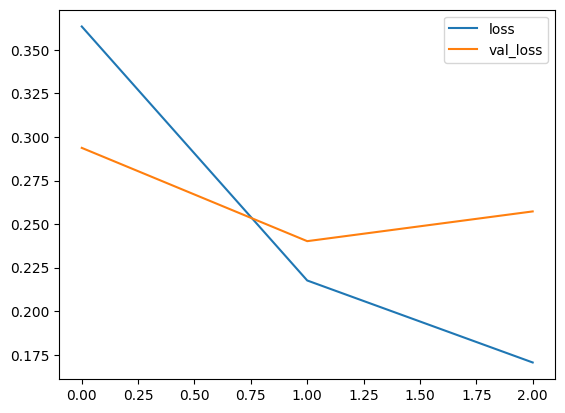

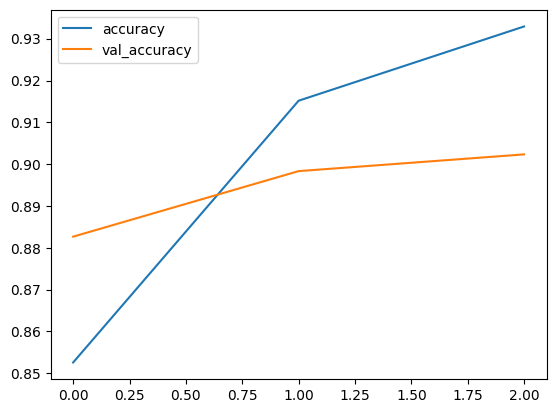

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [22]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step


In [23]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[955,   4,  28],
       [ 67, 910,   0],
       [194,   0, 842]])

In [24]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.79      0.97      0.87       987
      lung_n       1.00      0.93      0.96       977
    lung_scc       0.97      0.81      0.88      1036

    accuracy                           0.90      3000
   macro avg       0.92      0.90      0.90      3000
weighted avg       0.92      0.90      0.90      3000



In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load ResNet50 base
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a simple classification head
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)  # Adjust output layer to 3 classes
resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

# Freeze base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Simple data preparation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    'lung_image_sets',  # Replace with your dataset path
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)
val_generator = datagen.flow_from_directory(
    'lung_image_sets',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [34]:
# Train the model for a few epochs
history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,  # Fewer epochs for quick testing
    steps_per_epoch=20,
    validation_steps=10
)

# Evaluate the model
val_loss, val_accuracy = resnet_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4102 - loss: 1.0611 - val_accuracy: 0.3938 - val_loss: 1.0732
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5227 - loss: 1.0630 - val_accuracy: 0.4000 - val_loss: 1.0820
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4510 - loss: 1.0647 - val_accuracy: 0.4563 - val_loss: 1.0481
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4526 - loss: 1.0592 - val_accuracy: 0.4000 - val_loss: 1.0561
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4646 - loss: 1.0551 - val_accuracy: 0.5375 - val_loss: 1.0515
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5453 - loss: 1.0570 - val_accuracy: 0.4500 - val_loss: 1.0534
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4335 - loss: 1.0680 - val_accuracy: 0.5375 - val_loss: 1.0583
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.5975 - loss: 1.0557 - val_accuracy: 0.5375 - val_loss: